In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

In [4]:
df = pd.read_csv('binned_df.csv')
seed = 42
np.random.seed(seed)
train_ratio = 0.8
num_patients = df['PatientID'].nunique()
num_train_samples = int(num_patients * train_ratio)
train_ids = np.random.choice(num_patients, num_train_samples, replace=False)
train_df = df[df["PatientID"].isin(train_ids)].reset_index(drop=True)
test_df = df[~df["PatientID"].isin(train_ids)].reset_index(drop=True)
print(f'Train Data: {train_df.shape}')
print(f'Test Data: {test_df.shape}')

Train Data: (150144, 15)
Test Data: (37536, 15)


In [11]:
from ast import literal_eval
state_dict_df = pd.read_csv('state_dict.csv', header=None)
keys = state_dict_df.iloc[0].tolist()
values = state_dict_df.iloc[1].tolist()
state_dict = {tuple(literal_eval(key)): int(value) for key, value in zip(keys, values)}
print(state_dict)
action_dict = {(0, 0): 0, (0, 2): 1, (0, 3): 2, (0, 1): 3, (3, 0): 4, (2, 1): 5, (2, 0): 6, (3, 1): 7, (1, 0): 8, (1, 2): 9, (3, 3): 10, (2, 3): 11, (1, 1): 12, (3, 2): 13, (2, 2): 14, (1, 3): 15}
print(action_dict)

{(3, 1, 2, 2, 0, 0, 0, 0, 0, 3): 0, (2, 1, 2, 2, 0, 0, 0, 0, 1, 3): 1, (0, 1, 1, 2, 0, 0, 0, 0, 1, 3): 2, (2, 2, 1, 2, 1, 0, 0, 0, 0, 3): 3, (2, 2, 2, 2, 0, 0, 0, 0, 1, 3): 4, (2, 1, 1, 2, 0, 0, 0, 1, 3, 3): 5, (0, 1, 1, 2, 0, 0, 0, 1, 3, 3): 6, (0, 1, 1, 2, 0, 0, 0, 1, 1, 3): 7, (3, 2, 2, 2, 0, 0, 0, 1, 3, 3): 8, (3, 1, 2, 2, 0, 0, 0, 1, 3, 3): 9, (3, 1, 1, 2, 0, 0, 0, 1, 1, 3): 10, (1, 1, 1, 2, 0, 0, 0, 1, 0, 3): 11, (3, 2, 2, 2, 0, 0, 0, 1, 1, 3): 12, (3, 1, 2, 2, 0, 0, 0, 1, 1, 3): 13, (0, 1, 1, 2, 1, 0, 0, 1, 0, 3): 14, (3, 2, 1, 2, 0, 0, 0, 1, 1, 3): 15, (2, 1, 1, 2, 0, 0, 0, 1, 0, 3): 16, (3, 2, 2, 2, 0, 0, 0, 1, 0, 3): 17, (2, 1, 2, 2, 0, 0, 0, 1, 1, 3): 18, (1, 1, 2, 1, 0, 0, 0, 0, 1, 3): 19, (0, 1, 1, 1, 0, 0, 0, 1, 2, 3): 20, (2, 1, 1, 1, 0, 0, 0, 1, 2, 3): 21, (3, 1, 2, 1, 0, 0, 0, 0, 1, 3): 22, (1, 1, 2, 1, 0, 0, 0, 0, 2, 3): 23, (3, 1, 2, 2, 0, 0, 0, 0, 3, 3): 24, (0, 1, 1, 2, 0, 0, 0, 1, 2, 0): 25, (3, 2, 2, 1, 0, 0, 0, 1, 2, 0): 26, (2, 1, 1, 1, 0, 0, 0, 1, 2, 0): 27, (

In [77]:
alpha = 0.1
gamma = 0.99
num_simulations = 2
num_iterations = 10

state_columns = ['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'lactic_acid', 'serum_creatinine', 'p_f_ratio', 'GCS_total']
action_columns = ['fluid_boluses', 'vasopressors']

def calculate_reward(cur_SOFA, next_SOFA, cur_MAP, next_MAP):
    reward = 0
    c0 = -0.025
    c1 = -0.125
    c2 = 0.4
    map_reward = 0
    if cur_SOFA == next_SOFA and next_SOFA > 0:
        reward += c0
    if cur_MAP == 3 and next_MAP == 3: #MAP stays at normal level
        map_reward = 0
    elif cur_MAP == next_MAP: #MAP stays at low level
        map_reward = (-3 + cur_MAP) * 0.5
    elif cur_MAP > next_MAP: #MAP deteriorates
        map_reward = (next_MAP - cur_MAP) * (4 - cur_MAP) * 0.8
    elif cur_MAP < next_MAP: #MAP improves
        map_reward = next_MAP - cur_MAP
    return reward + c1 * (next_SOFA - cur_SOFA) + c2 * map_reward

def calculate_sofa_score(MAP, dbp, sbp, urine, ALT, AST, lactic_acid, serum_creatinine, p_f_ratio, GCS_total):
    cardiovascular_score = 0
    if MAP < 3:
        cardiovascular_score = 1

    respitory_score = 0
    if p_f_ratio == 0:
        respitory_score = 4
    elif p_f_ratio == 1:
        respitory_score = 3
    elif p_f_ratio == 2:
        respitory_score = 2
    else:
        respitory_score = 1

    renal_score = serum_creatinine

    if urine == 1:
        renal_score = max(renal_score, 3)
    if urine == 0:
        renal_score = max(renal_score, 4)

    liver_score = 0
    if (ALT > 0 and AST > 0):
        liver_score = 1
    if (ALT > 1 or AST > 1):
        liver_score = 2
    if (ALT > 2 or AST > 2):
        liver_score = 3

    neuro_score = 0
    if GCS_total == 0:
        neuro_score = 4
    elif GCS_total == 1:
        neuro_score = 3
    elif GCS_total  == 2:
        neuro_score = 2
    elif GCS_total == 3:
        neuro_score = 1

    lactic_acid_score = 0
    if lactic_acid > 0:
        lactic_acid_score = 2

    return cardiovascular_score + respitory_score + renal_score + liver_score + neuro_score + lactic_acid_score


In [12]:
def create_transitions(df):
    X = []
    y = []
    patients = df['PatientID'].unique()

    for patient in patients:
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        for i in range(len(patient_records) - 1):
            current_state = patient_records.iloc[i][state_columns]
            next_state = patient_records.iloc[i + 1][state_columns]
            action = patient_records.iloc[i][action_columns]
            X.append(np.concatenate([current_state, action]))
            y.append(next_state)
    return pd.DataFrame(X, columns=state_columns + action_columns), pd.DataFrame(y, columns=state_columns)

X, y = create_transitions(train_df)

In [13]:
#use K nearest neighbours to calculate next state prediction (function approximation for transitions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn_models = {col: KNeighborsClassifier(n_neighbors=20) for col in state_columns}

for col in state_columns:
    knn_models[col].fit(X_train, y_train[col])

#evaluate accuracy
predictions = pd.DataFrame()
for col in state_columns:
    predictions[col] = knn_models[col].predict(X_test)
    accuracy = accuracy_score(y_test[col], predictions[col])
    print(f"Accuracy for predicting {col}: {accuracy:.2f}")

Accuracy for predicting MAP: 0.51
Accuracy for predicting diastolic_bp: 0.69
Accuracy for predicting systolic_bp: 0.67
Accuracy for predicting urine: 0.71
Accuracy for predicting ALT: 0.81
Accuracy for predicting AST: 0.80
Accuracy for predicting lactic_acid: 0.93
Accuracy for predicting serum_creatinine: 0.85
Accuracy for predicting p_f_ratio: 0.63
Accuracy for predicting GCS_total: 0.89


In [147]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

columns = ['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST',
           'lactic_acid', 'serum_creatinine', 'p_f_ratio', 'GCS_total']
context_features = ['fluid_boluses', 'vasopressors']
results = {}

class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

for target_col in columns:
    X_train_col = X_train[[target_col] + context_features]
    X_test_col = X_test[[target_col] + context_features]
    y_train_col = y_train[[target_col]]
    y_test_col = y_test[[target_col]]

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_col.values.ravel())
    y_test_encoded = label_encoder.transform(y_test_col.values.ravel())
    num_classes = len(label_encoder.classes_)

    X_train_tensor = torch.tensor(X_train_col.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_col.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

    model = NeuralNet(input_size=X_train_tensor.shape[1], output_size=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(loss)

    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        _, predicted_classes = torch.max(predictions, 1)
        accuracy = accuracy_score(y_test_tensor.numpy(), predicted_classes.numpy()) * 100

        results[target_col] = accuracy
    break

for col, accuracy in results.items():
    print(f"Accuracy for {col}: {accuracy:.2f}%")


tensor(1.3389, grad_fn=<NllLossBackward0>)
tensor(1.2194, grad_fn=<NllLossBackward0>)
tensor(1.1909, grad_fn=<NllLossBackward0>)
tensor(1.1851, grad_fn=<NllLossBackward0>)
tensor(1.1834, grad_fn=<NllLossBackward0>)
tensor(1.1827, grad_fn=<NllLossBackward0>)
tensor(1.1823, grad_fn=<NllLossBackward0>)
tensor(1.1821, grad_fn=<NllLossBackward0>)
tensor(1.1820, grad_fn=<NllLossBackward0>)
tensor(1.1819, grad_fn=<NllLossBackward0>)
Accuracy for MAP: 51.81%


In [14]:
def return_state_action_df(row, fluid, vaso):
    state_action = {
        'MAP': row['MAP'].item(),
        'diastolic_bp': row['diastolic_bp'].item(),
        'systolic_bp': row['systolic_bp'].item(),
        'urine': row['urine'].item(),
        'ALT': row['ALT'].item(),
        'AST': row['AST'].item(),
        'lactic_acid': row['lactic_acid'].item(),
        'serum_creatinine': row['serum_creatinine'].item(),
        'p_f_ratio':row['p_f_ratio'].item(),
        'GCS_total': row['GCS_total'].item(),
        'fluid_boluses': fluid,
        'vasopressors': vaso
    }
    return pd.DataFrame([state_action])

In [24]:
def clinician_cumulative_reward(df):
    patients = df['PatientID'].unique()
    total_cumulative_reward = 0
    rewards = []
    for patient in patients:
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        for i in range(len(patient_records) - 1):
            current_state = patient_records.iloc[i][state_columns]
            next_state = patient_records.iloc[i + 1][state_columns]
            #action = patient_records.iloc[i][action_columns]
            cur_sofa = calculate_sofa_score(*current_state)
            next_sofa = calculate_sofa_score(*next_state)
            reward = calculate_reward(cur_sofa, next_sofa, current_state['MAP'], next_state['MAP'])
            rewards.append(reward)
            total_cumulative_reward += reward
    return total_cumulative_reward, rewards

In [25]:
r1, rl1 = clinician_cumulative_reward(test_df)
print("total cumulative reward (clinician) per patient with SOFA score reward:", r1 / 782)


total cumulative reward (clinician) per patient with SOFA score reward: -2.7210038363172044


In [81]:
def no_action_cumulative_reward(df):
    patients = df['PatientID'].unique()
    total_cumulative_reward = 0
    #rewards = []
    j = 0
    for patient in patients:
        #print(patient)
        if j % 20 == 0:
            print(j)
        j+=1
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        current_state = patient_records.iloc[0][state_columns].tolist()

        for i in range(len(patient_records) - 1):
            predicted_next_state = pd.DataFrame()
            input_data = current_state + [0,0]
            input_data_df = pd.DataFrame([input_data], columns=['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'lactic_acid', 'serum_creatinine', 'p_f_ratio', 'GCS_total', 'fluid_boluses', 'vasopressors'])
            for col in state_columns:
                predicted_next_state[col] = knn_models[col].predict(input_data_df)
            next_state = predicted_next_state.iloc[0].tolist()
            cur_sofa = calculate_sofa_score(*current_state)
            next_sofa = calculate_sofa_score(*next_state)

            cur_map = current_state[0]
            next_map = next_state[0]

            reward = calculate_reward(cur_sofa, next_sofa, cur_map, next_map)
            #rewards.append(reward)
            total_cumulative_reward += reward
            current_state = next_state
    return total_cumulative_reward#, rewards

In [82]:
r2 = no_action_cumulative_reward(test_df)
print("total cumulative reward (no action) per patient with SOFA score reward:", r2 / 782)


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
total cumulative reward (no action) per patient with SOFA score reward: -1.9382352941180303


In [83]:
#read trained q table
q_table_df = pd.read_csv('q_table_trained.csv', index_col=0)
q_table = q_table_df.values
print(q_table)

[[0.07839044 0.07055499 0.0666095  ... 0.06408475 0.10025977 0.11510394]
 [0.23161799 0.29422575 0.15855727 ... 0.05835328 0.03996786 0.065     ]
 [1.193965   1.0604911  0.5941178  ... 0.2957849  0.10586377 0.62132084]
 ...
 [0.07456733 0.5172349  0.12447707 ... 0.1150382  0.10616922 0.2468797 ]
 [0.8001241  0.66878736 1.1317015  ... 0.1396769  0.4939617  0.8769343 ]
 [0.33437628 0.23554677 0.23180771 ... 0.35032752 0.25622782 0.39000297]]


In [84]:
inverse_action_dict = {v: k for k, v in action_dict.items()}

def select_optimal_action(state_index, q_table):
    best_action_index = np.argmax(q_table[state_index]).item()
    best_action = inverse_action_dict[best_action_index]
    return best_action

def dynaq_action_cumulative_reward(df):
    patients = df['PatientID'].unique()
    total_cumulative_reward = 0
    #rewards = []
    j = 0
    for patient in patients:
        #print(patient)
        if j % 20 == 0:
            print(j)
        j+=1
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        current_state = patient_records.iloc[0][state_columns].tolist()

        for i in range(len(patient_records) - 1):
            predicted_next_state = pd.DataFrame()
            cur_state_idx = state_dict[tuple(current_state)]
            fluid, vaso = select_optimal_action(cur_state_idx, q_table)
            input_data = current_state + [fluid, vaso]
            input_data_df = pd.DataFrame([input_data], columns=['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'lactic_acid', 'serum_creatinine', 'p_f_ratio', 'GCS_total', 'fluid_boluses', 'vasopressors'])
            for col in state_columns:
                predicted_next_state[col] = knn_models[col].predict(input_data_df)
            next_state = predicted_next_state.iloc[0].tolist()
            cur_sofa = calculate_sofa_score(*current_state)
            next_sofa = calculate_sofa_score(*next_state)

            cur_map = current_state[0]
            next_map = next_state[0]

            reward = calculate_reward(cur_sofa, next_sofa, cur_map, next_map)
            #rewards.append(reward)
            total_cumulative_reward += reward
            current_state = next_state
    return total_cumulative_reward#, rewards

In [85]:
r3 = no_action_cumulative_reward(test_df)
print("total cumulative reward (dyna-Q policy) per patient with SOFA score reward:", r3 / 782)

0


KeyboardInterrupt: 

In [121]:
def find_closest_index(input_tuple):
    closest_index = None
    min_distance = float('inf')

    for value, index in state_dict.items():
        distance = np.linalg.norm(np.array(value) - np.array(input_tuple))

        if distance < min_distance:
            min_distance = distance
            closest_index = index

    return closest_index

def dynaq_action_dist(df):
    patients = df['PatientID'].unique()
    total_cumulative_reward = 0
    maps = []
    fluids = []
    vasos = []
    j = 0
    for patient in patients:
        #print(patient)
        if j % 20 == 0:
            print(j)
        j+=1
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)


        for i in range(len(patient_records) - 1):
            current_state = patient_records.iloc[i][state_columns].tolist()
            cur_state_idx = state_dict[tuple(current_state)] if tuple(current_state) in state_dict else find_closest_index(tuple(current_state))
            fluid, vaso = select_optimal_action(cur_state_idx, q_table)
            maps.append(current_state[0])
            fluids.append(fluid)
            vasos.append(vaso)
    return maps, fluids, vasos

In [122]:
print(len(state_dict))

10912


In [123]:
dynaq_map, dynaq_fluids, dynaq_vasopressors = dynaq_action_dist(test_df)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780


In [124]:
#MAP vs action plot
import matplotlib.pyplot as plt
import seaborn as sns

#dynaq_map = [0,0,1,2,3]
#dynaq_fluids = [3,2,0,1,0]
#dynaq_vasopressors = [2,1,0,0,0]

policy_df = pd.DataFrame()
policy_df['MAP_tier'] = dynaq_map
policy_df['dynaq_fluid'] = dynaq_fluids
policy_df['dynaq_vasopressor'] = dynaq_vasopressors

dynaq_action_counts = policy_df.groupby(["MAP_tier", "dynaq_fluid", "dynaq_vasopressor"]).size().reset_index(name="dynaq_count")

def get_action_proportion(action_count_df, policy, action_name):
    counts = action_count_df.groupby(["MAP_tier", f"{policy}_{action_name}"])[f"{policy}_count"].sum()
    #print(counts)
    proportions = counts.groupby(level=0, group_keys=False).apply(lambda x: x / x.sum()).reset_index(name='Proportion of Actions')

    proportions = proportions.rename(columns={f"{policy}_{action_name}": action_name})
    #print(proportions)
    return proportions

In [125]:
fluid_palette = sns.color_palette("Blues", n_colors=4)
vaso_palette = sns.color_palette("Reds", n_colors=4)

'\nsns.barplot(data=dynaq_vaso_proportions, x=\'MAP Tier\', y=\'Proportion of Actions\', hue=\'Vasopressors\', \n                palette=sns.color_palette("Reds", n_colors=4), ax=axes[0], legend=None)\naxes[0].set_title(f"DynaQ (SOFA-Based Reward) - Vasopressors")\nplt.ylim(0, 1)\n'

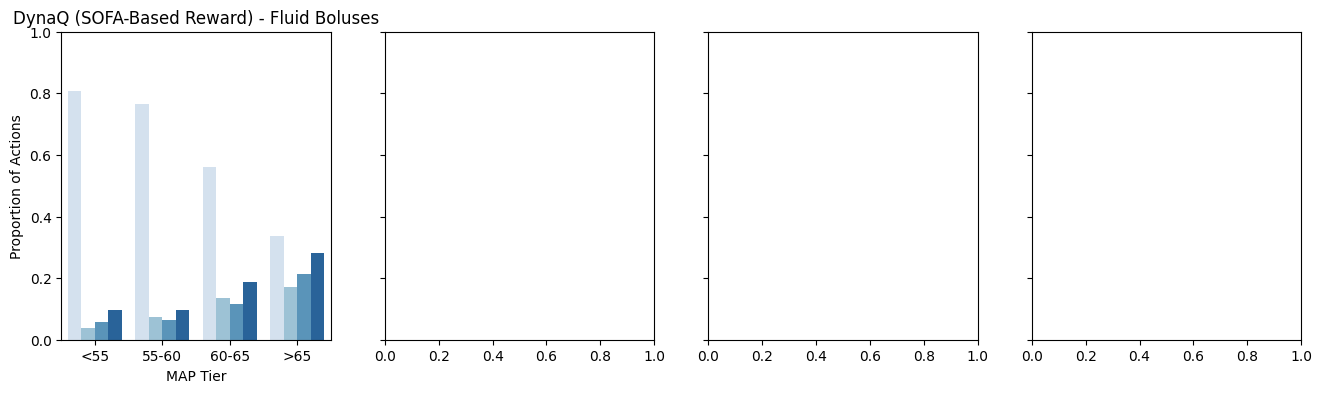

In [127]:
dynaq_fluid_proportions = get_action_proportion(dynaq_action_counts, "dynaq", "fluid")
dynaq_vaso_proportions = get_action_proportion(dynaq_action_counts, "dynaq", "vasopressor")
#map MAP and actions from 0,1,2,3 to text
fluid_bolus_order = {0: "[0, 250)", 1: "[250, 500)", 2: "[500, 1000)", 3: ">= 1000"}
vasopressor_order = {0: "0", 1: "(0, 8.4)", 2: "[8.4, 20.28)", 3: ">= 20.28"}
map_tier_order = bl = {0: "<55", 1: "55-60", 2: "60-65", 3: ">65"}
dynaq_fluid_proportions['Fluid Boluses'] = dynaq_fluid_proportions['fluid'].map(fluid_bolus_order)
dynaq_fluid_proportions['MAP Tier'] = dynaq_fluid_proportions['MAP_tier'].map(map_tier_order)
dynaq_vaso_proportions['Vasopressors'] = dynaq_vaso_proportions['vasopressor'].map(vasopressor_order)
dynaq_vaso_proportions['MAP Tier'] = dynaq_vaso_proportions['MAP_tier'].map(map_tier_order)
dynaq_fluid_proportions.drop('fluid', axis='columns', inplace=True)
dynaq_vaso_proportions.drop('vasopressor', axis='columns', inplace=True)
#Dyna-Q - Fluid Boluse
#print(dynaq_fluid_proportions)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey='row')

sns.barplot(data=dynaq_fluid_proportions, x='MAP Tier', y='Proportion of Actions', hue='Fluid Boluses',
            palette=sns.color_palette("Blues", n_colors=4), ax=axes[0], legend=None)
axes[0].set_title(f"DynaQ (SOFA-Based Reward) - Fluid Boluses")
plt.ylim(0, 1)
'''
sns.barplot(data=dynaq_vaso_proportions, x='MAP Tier', y='Proportion of Actions', hue='Vasopressors',
                palette=sns.color_palette("Reds", n_colors=4), ax=axes[0], legend=None)
axes[0].set_title(f"DynaQ (SOFA-Based Reward) - Vasopressors")
plt.ylim(0, 1)
'''

In [92]:
dynaq_fluid_proportions.to_csv('dynaq_fluid_proportions.csv')
dynaq_vaso_proportions.to_csv('dynaq_vaso_proportions.csv')